In [1]:
import cv2
import ast
import os
import json
import numpy as np
import tensorflow as tf
import math
import collections
import sys
import matplotlib.pyplot as plt
from matplotlib.image import imread
import Network as net
from For_Demo_Hand import OpenPose_Demo_Hand

from scipy.ndimage.filters import maximum_filter
from collections import Counter, defaultdict
import itertools
import matplotlib as mpl
from scipy.ndimage.filters import gaussian_filter
import matplotlib
import time

C:\Users\SimJaekyu\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
MPII_Pairs = [(0, 1), (0, 5), (0, 9), (0, 13), (0, 17), (1, 2), (2, 3), (3, 4), (5, 6), (6, 7), (7, 8), (9, 10), (10, 11), (11, 12), (13, 14), (14, 15), (15, 16), (17, 18), (18, 19), (19, 20)]#16개 조인트, 15개 limb
MPII_Pairs_Render = MPII_Pairs[:]
MPII_Pairs_Network = [(0, 1),(8, 9),(16, 17),(24, 25),(32, 33),(2, 3),(4, 5),(6, 7),(10, 11),(12, 13),(14, 15),(18, 19),(20, 21),(22, 23),(26, 27),(28, 29),(30, 31),(34, 35),(36,37 ),(38, 39)]

MPII_Colors = [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0],\
              [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0],\
              [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0],\
              [0, 0, 0]]



InterMinAbove_Threshold = 6
Inter_Threashold = 1e-08#0.1
Min_Subset_Cnt = 0#4
Min_Subset_Score = 0.01#0.8
#Max_Human = 96
def non_max_suppression(np_input, window_size=5, threshold=0.1):
    under_threshold_indices = np_input < threshold
    np_input[under_threshold_indices] = 0
    return np_input*(np_input == maximum_filter(np_input, footprint=np.ones((window_size, window_size))))

def estimate_pose(coords, heatmap_buffer, heatmap, vectormap):
    """
    0 - r_ankle
    1 - r_knee
    2 - r_hip
    3 - l_hip
    4 - l_knee
    5 - l_ankle
    6 - pelvis
    7 - thorax
    8 - upper neck
    9 - head top
    10 - r_wrist
    11 - r_elbow
    12 - r_sholder
    13 - l_sholder
    14 - l_elbow
    15 - l_wrist
    16 - back_ground
    """

    connection_all = []
    for (idx1, idx2), (paf_x_idx, paf_y_idx) in zip(MPII_Pairs, MPII_Pairs_Network):
        print("idx1, idx2 : ", idx1, idx2)
        print("paf_x_idx, paf_y_idx : ", paf_x_idx, paf_y_idx)
        connection = estimate_pose_pair(coords, idx1, idx2, vectormap[paf_x_idx], vectormap[paf_y_idx])
        #print("estimate_pose -> idx1, idx2 : ",idx1, idx2)
        #estimate_pose_pair(coords, idx1, idx2, vectormap[paf_x_idx], vectormap[paf_y_idx])
        connection_all.extend(connection)

    print("connection_all : ", connection_all)
    connection_by_human = dict()
    for idx, c in enumerate(connection_all):
        connection_by_human['human_%d' % idx] = [c]
    print("connection_by_human : ", connection_by_human)
    no_merge_cache = defaultdict(list)

    while True:
        is_merged = False
        for k1, k2 in itertools.combinations(connection_by_human.keys(), 2):
            if k1 == k2:
                continue
            if k2 in no_merge_cache[k1]:
                continue
            for c1, c2 in itertools.product(connection_by_human[k1], connection_by_human[k2]):
                if len(set(c1['uPartIdx']) & set(c2['uPartIdx'])) > 0:
                    is_merged = True
                    connection_by_human[k1].extend(connection_by_human[k2])
                    connection_by_human.pop(k2)
                    break
            if is_merged:
                no_merge_cache.pop(k1, None)
                break
            else:
                no_merge_cache[k1].append(k2)

        if not is_merged:
            break


    connection_by_human = {k: v for (k, v) in connection_by_human.items() if len(v) >= Min_Subset_Cnt}
    # reject by subset max score
    print("connection_by_human2 : ", connection_by_human)
    connection_by_human = {k: v for (k, v) in connection_by_human.items() if max([ii['score'] for ii in v])\
                           >= Min_Subset_Score}
    print("connection_by_human2 : ", connection_by_human)
    return [connections_to_human(conn, heatmap_buffer) for conn in connection_by_human.values()]

def connections_to_human(connections, heatMat):
    point_dict = defaultdict(lambda: None)
    for conn in connections:
        point_dict[conn['partIdx'][0]] = (conn['partIdx'][0], (conn['c1'][0] / heatMat.shape[2], conn['c1'][1] / heatMat.shape[1]), heatMat[conn['partIdx'][0], conn['c1'][1], conn['c1'][0]])
        point_dict[conn['partIdx'][1]] = (conn['partIdx'][1], (conn['c2'][0] / heatMat.shape[2], conn['c2'][1] / heatMat.shape[1]), heatMat[conn['partIdx'][1], conn['c2'][1], conn['c2'][0]])
    return point_dict

def estimate_pose_pair(coords, partIdx1, partIdx2, pafMatX, pafMatY):

    connection_temp = []
    peak_coord1, peak_coord2 = coords[partIdx1], coords[partIdx2]
    cnt = 0
    print("peak_coord1, peak_coord2 : ", peak_coord1, peak_coord2)
    for idx1, (y1, x1) in enumerate(zip(peak_coord1[0], peak_coord1[1])):
        for idx2, (y2, x2) in enumerate(zip(peak_coord2[0], peak_coord2[1])):
            print("estimate_pose_pair -> x1, y1, x2, y2 : ", x1, y1, x2, y2)
            score, count = get_score(x1, y1, x2, y2, pafMatX, pafMatY)
            cnt = cnt + 1
            print("estimate_pose_pair -> score : ", score, "idx : ", (idx1, idx2) )
            if (partIdx1, partIdx2) in [(12, 11), (11, 10), (13, 14), (14, 15)]:
                print("estimate_pose_pair -> partIdx1, partIdx2 : ", partIdx1, partIdx2)
                if (count < (InterMinAbove_Threshold // 2) or score <= 0.0):#count < InterMinAbove_Threshold // 2 or 
                    print("estimate_pose_pair -> okokokokokokokokok")
                    continue
            
            elif (count < InterMinAbove_Threshold or  score <= 0.0):#count < InterMinAbove_Threshold or 
                print("estimate_pose_pair -> ----------------------------")
                continue
            print("estimate_pose_pair -> if 통과")
            connection_temp.append({
                'score': score,
                'c1': (x1, y1),
                'c2': (x2, y2),
                'idx': (idx1, idx2),
                'partIdx': (partIdx1, partIdx2),
                'uPartIdx': ('{}-{}-{}'.format(x1, y1, partIdx1), '{}-{}-{}'.format(x2, y2, partIdx2))
            })
            
            print("estimate_pose_pair -> connection temp : ", connection_temp)#empty
    connection = []
    used_idx1, used_idx2 = [], []
    for candidate in sorted(connection_temp, key=lambda x: x['score'], reverse=True):
        # check not connected
        if candidate['idx'][0] in used_idx1 or candidate['idx'][1] in used_idx2:
            continue
        connection.append(candidate)
        used_idx1.append(candidate['idx'][0])
        used_idx2.append(candidate['idx'][1])
    #print("connection : ",connection)
    return connection
def get_score(x1, y1, x2, y2, pafMatX, pafMatY):
    __num_inter = 10
    __num_inter_f = float(__num_inter)
    dx, dy = x2 - x1, y2 - y1
    normVec = math.sqrt(dx ** 2 + dy ** 2)

    if normVec < 1e-4:
        return 0.0, 0

    vx, vy = dx / normVec, dy / normVec

    xs = np.arange(x1, x2, dx / __num_inter_f) if x1 != x2 else np.full((__num_inter, ), x1)
    ys = np.arange(y1, y2, dy / __num_inter_f) if y1 != y2 else np.full((__num_inter, ), y1)
    xs = (xs + 0.5).astype(np.int8)
    ys = (ys + 0.5).astype(np.int8)

    # without vectorization
    pafXs = np.zeros(__num_inter)
    pafYs = np.zeros(__num_inter)
    """for idx, (mx, my) in enumerate(zip(xs, ys)):
        print("get_score -> my, mx : ",my, mx)
        print("get_score -> pafXs's shape : ",np.shape(pafXs))
        print("get_score -> pafYs's shape : ",np.shape(pafYs))

        pafXs[idx] = pafMatX[my][mx]#[my][mx]
        pafYs[idx] = pafMatY[my][mx]"""

    # vectorization slow?
    pafXs = pafMatX[ys, xs]
    pafYs = pafMatY[ys, xs]

    local_scores = pafXs * vx + pafYs * vy
    thidxs = local_scores > Inter_Threashold

    return sum(local_scores * thidxs), sum(thidxs)


def cb_showimg(img, preprocessed, heatmap, vectormap, humans, show_process=False):

    # display
    image = img
    image_w, image_h = image.shape[:2]
    image = draw_humans(image, humans)
    scale = 356.0 / image_w
    newh, neww = 356, int(scale * image_h + 0.5)

    image = cv2.resize(image, (neww, newh), interpolation=cv2.INTER_AREA)

    if show_process:
        process_img = display_image(preprocessed, heatmap, vectormap, as_numpy=True)
        process_img = cv2.resize(process_img, (356 + 356, 356), interpolation=cv2.INTER_AREA)

        canvas = np.zeros([356, 356 + 356 + neww, 3], dtype=np.uint8)
        canvas[:, :356 + 356] = process_img
        canvas[:, 356 + 356 :] = image

    else:
        canvas = image

    #cv2.putText(canvas, "FPS: %f" % (1.0 / (time.time() - fps_time)), (10, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    #cv2.imshow('openpose', canvas)
    plt.imsave("result.jpg", canvas)
    plt.imshow(canvas, aspect='auto')
    plt.show()


def draw_humans(img, human_list):
    img_copied = np.copy(img)
    image_w, image_h = img_copied.shape[:2]
    #print(np.shape(img_copied))
    centers = {}
    for human in human_list:
        part_idxs = human.keys()
        #print("part_idxs : ", part_idxs)
        # draw point
        for i in range(17):
            if i not in part_idxs:
                continue
            part_coord = human[i][1]
            center = (int(part_coord[0] * image_w + 0.5), int(part_coord[1] * image_h + 0.5))
            print("center : ", center)
            centers[i] = center
            #m = im.transpose((1, 2, 0)).astype(np.uint8).copy() 
            img_copied = img_copied.astype(np.float32).copy()
            cv2.circle(img_copied, center, 3, MPII_Colors[i], thickness=3, lineType=8, shift=0)

        # draw line
        #for pair_order, pair in enumerate(MPII_Pairs_Render):
        #    if pair[0] not in part_idxs or pair[1] not in part_idxs:
        #        continue
        #
        #    img_copied = cv2.line(img_copied, centers[pair[0]], centers[pair[1]], MPII_Colors[pair_order], 3)

    return img_copied

def display_image(inp, heatmap, vectmap, as_numpy=False):
    if as_numpy:
        mpl.use('Agg')

    fig = plt.figure()
    a = fig.add_subplot(2, 2, 1)
    a.set_title('Image')
    plt.imshow(get_bgimg(inp))

    a = fig.add_subplot(2, 2, 2)
    a.set_title('Heatmap')
    #inp = inp.transpose((2, 0, 1))
    #print(np.shape(heatmap))#17 44 44
    plt.imshow(get_bgimg(inp, target_size=(heatmap.shape[1], heatmap.shape[2])), alpha=0.5)################
    #heatmap = heatmap.transpose((2, 0, 1))
    tmp = np.amax(heatmap, axis=0)
    
    plt.imshow(tmp, cmap=plt.cm.gray, alpha=0.5)
    plt.colorbar()

    tmp2 = vectmap.transpose((2, 0, 1))
    tmp2_odd = np.amax(np.absolute(tmp2[::2, :, :]), axis=0)
    tmp2_even = np.amax(np.absolute(tmp2[1::2, :, :]), axis=0)

    a = fig.add_subplot(2, 2, 3)
    a.set_title('Vectormap-x')
    plt.imshow(get_bgimg(inp, target_size=(vectmap.shape[0], vectmap.shape[1])), alpha=0.5)
    plt.imshow(tmp2_odd, cmap=plt.cm.gray, alpha=0.5)
    plt.colorbar()

    a = fig.add_subplot(2, 2, 4)
    a.set_title('Vectormap-y')
    plt.imshow(get_bgimg(inp, target_size=(vectmap.shape[0], vectmap.shape[1])), alpha=0.5)
    plt.imshow(tmp2_even, cmap=plt.cm.gray, alpha=0.5)
    plt.colorbar()

    if not as_numpy:
        plt.show()
    else:
        fig.canvas.draw()
        data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        fig.clear()
        plt.close()
        return data
def get_bgimg(inp, target_size=None):
    if target_size:
        inp = cv2.resize(inp, target_size, interpolation=cv2.INTER_AREA)
    inp = cv2.cvtColor(((inp + 1.0) * (255.0 / 2.0)).astype(np.uint8), cv2.COLOR_BGR2RGB)
    return inp
def preprocess(img, width, height):
    val_image = cv2.resize(img, (width, height))
    val_image = val_image.astype(float)
    val_image = val_image * (2.0 / 255.0) - 1.0
    return val_image

In [3]:
def make_batch(img_path, anno_data, batch_size = 16):
    num_of_data = len(img_path)
    index = np.arange(0, num_of_data)
    np.random.shuffle(index)
    index = index[:batch_size]
    
    shuffled_img_data = [img_path[i] for i in index]
    #shuffled_anno_data = [anno_data[j] for j in index]
    shuffled_anno_data = [[anno_data[j:j+1]][0][0] for j in index]
    #shuffled_anno_data = [anno_data[j:j+1][0][0][0] for j in index]
    
    return np.asarray(shuffled_img_data), np.asarray(shuffled_anno_data)

def load_data():
    joint_result = np.load('./dataset/Hands/hand_labels/Annotation/cropped_resized_hands_joint_data.npy')
    train_file_list = np.load('./dataset/Hands/hand_labels/Annotation/cropped_resized_hands_img_list.npy')
    return train_file_list, joint_result

def path_to_image(img_path, batch_size):
    #buffer 선언
    image_data = np.zeros((batch_size, 356, 356, 3), np.uint8)
    
    index = 0
    for img in (img_path):
        image_data[index] = cv2.imread(img)
        index = index + 1

    return image_data

In [4]:
batch_size = 8
image_path, annotation_data = load_data()
batch_img_path, batch_annotation= make_batch(img_path = image_path, anno_data = annotation_data, batch_size = batch_size)
batch_img = path_to_image(batch_img_path, batch_size)

In [5]:
with tf.Session() as sess:
    obj = OpenPose_Demo_Hand(sess = sess, batch_size = 8)
    confidencemap, PAFs = obj.demo_test(batch_img)

open pose demo init complete
INFO:tensorflow:Restoring parameters from C:/Users/SimJaekyu/Documents/Jupyter Notebook/Pose_Estimation_with_Hand/Weight_Hand/Weight.ckpt
Training Weight load


In [30]:
index = 5
index2 = index

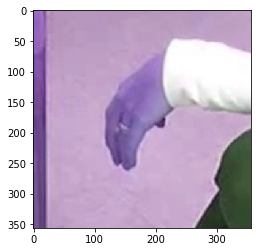

./dataset/Hands/hand_labels/Cropped_Resized_Image/073877803_02_l.jpg


In [31]:
plt.imshow(batch_img[index])
plt.show()
print(batch_img_path[index])

(22, 44, 44)


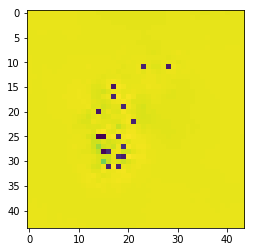

(8, 44, 44, 44)


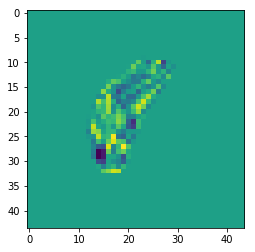

In [32]:
_confidencemap = np.transpose(confidencemap[index], [2, 1, 0])
print(np.shape(_confidencemap))
plt.imshow(_confidencemap[21])
plt.show()
print(np.shape(PAFs))
_PAFs = np.transpose(PAFs[index], [2, 1, 0])
plt.imshow(_PAFs[43])
plt.show()

In [33]:
oriImg = batch_img[index]
heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 22))
paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 44))

resized_heatmap = np.zeros((22, 356, 356), dtype=np.float32)
resized_vectormap = np.zeros((44, 356, 356), dtype=np.float32)
print(np.shape(_confidencemap))
for i in range(22):
    resized_heatmap[i] = cv2.resize(_confidencemap[i], (356, 356))
for i in range(44):
    resized_vectormap[i] = cv2.resize(_PAFs[i], (356, 356))
    
transposed_resized_heatmap = np.transpose(resized_heatmap, [1, 2, 0])
nt_vectormap = np.transpose(resized_vectormap, [1, 2, 0])

heatmap_avg = heatmap_avg + transposed_resized_heatmap
paf_avg = paf_avg + nt_vectormap

(22, 44, 44)


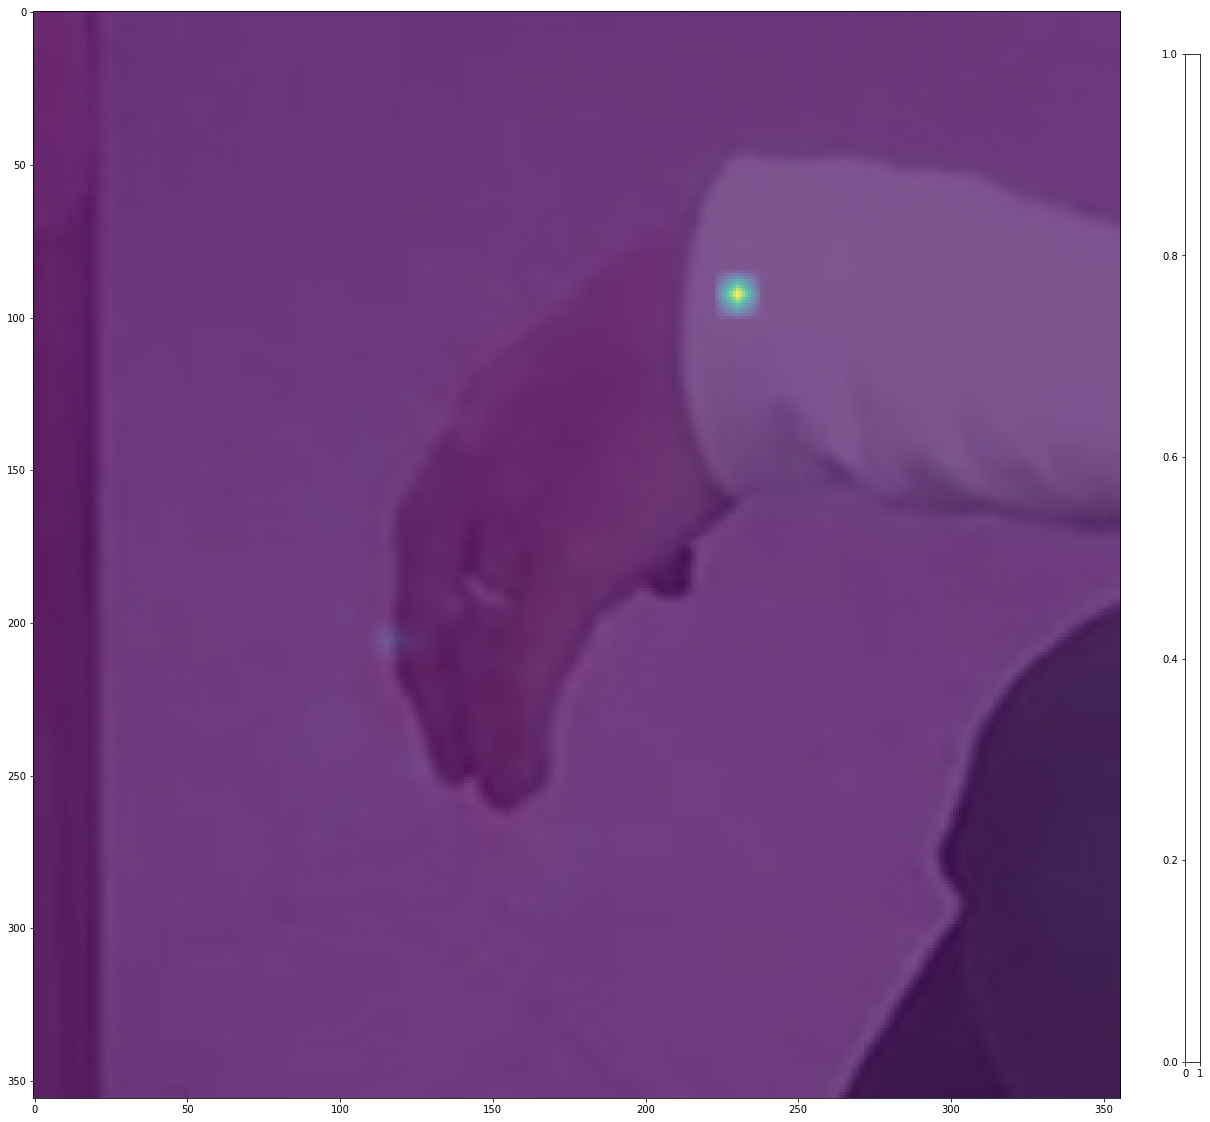

In [34]:
plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(heatmap_avg[:,:,0], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, 
fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(20, 20)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
#_ = fig.colorbar(oriImg, cax=cbar_ax)

In [29]:
"""plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(heatmap_avg[:,:,1], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, 
fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(20, 20)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
#_ = fig.colorbar(oriImg, cax=cbar_ax)"""

'plt.imshow(oriImg[:,:,[2,1,0]])\nplt.imshow(heatmap_avg[:,:,1], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, \nfig = matplotlib.pyplot.gcf()\ncax = matplotlib.pyplot.gca()\nfig.set_size_inches(20, 20)\nfig.subplots_adjust(right=0.93)\ncbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])\n#_ = fig.colorbar(oriImg, cax=cbar_ax)'

In [18]:
"""plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(heatmap_avg[:,:,2], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, 
fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(20, 20)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
#_ = fig.colorbar(oriImg, cax=cbar_ax)"""

'plt.imshow(oriImg[:,:,[2,1,0]])\nplt.imshow(heatmap_avg[:,:,2], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, \nfig = matplotlib.pyplot.gcf()\ncax = matplotlib.pyplot.gca()\nfig.set_size_inches(20, 20)\nfig.subplots_adjust(right=0.93)\ncbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])\n#_ = fig.colorbar(oriImg, cax=cbar_ax)'

In [19]:
"""plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(heatmap_avg[:,:,3], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, 
fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(20, 20)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
#_ = fig.colorbar(oriImg, cax=cbar_ax)"""

'plt.imshow(oriImg[:,:,[2,1,0]])\nplt.imshow(heatmap_avg[:,:,3], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, \nfig = matplotlib.pyplot.gcf()\ncax = matplotlib.pyplot.gca()\nfig.set_size_inches(20, 20)\nfig.subplots_adjust(right=0.93)\ncbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])\n#_ = fig.colorbar(oriImg, cax=cbar_ax)'

In [20]:
"""plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(heatmap_avg[:,:,4], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, 
fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(20, 20)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
#_ = fig.colorbar(oriImg, cax=cbar_ax)"""

'plt.imshow(oriImg[:,:,[2,1,0]])\nplt.imshow(heatmap_avg[:,:,4], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, \nfig = matplotlib.pyplot.gcf()\ncax = matplotlib.pyplot.gca()\nfig.set_size_inches(20, 20)\nfig.subplots_adjust(right=0.93)\ncbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])\n#_ = fig.colorbar(oriImg, cax=cbar_ax)'

In [21]:
"""plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(heatmap_avg[:,:,5], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, 
fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(20, 20)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
#_ = fig.colorbar(oriImg, cax=cbar_ax)"""

'plt.imshow(oriImg[:,:,[2,1,0]])\nplt.imshow(heatmap_avg[:,:,5], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, \nfig = matplotlib.pyplot.gcf()\ncax = matplotlib.pyplot.gca()\nfig.set_size_inches(20, 20)\nfig.subplots_adjust(right=0.93)\ncbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])\n#_ = fig.colorbar(oriImg, cax=cbar_ax)'

In [22]:
"""plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(heatmap_avg[:,:,6], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, 
fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(20, 20)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
#_ = fig.colorbar(oriImg, cax=cbar_ax)"""

'plt.imshow(oriImg[:,:,[2,1,0]])\nplt.imshow(heatmap_avg[:,:,6], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, \nfig = matplotlib.pyplot.gcf()\ncax = matplotlib.pyplot.gca()\nfig.set_size_inches(20, 20)\nfig.subplots_adjust(right=0.93)\ncbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])\n#_ = fig.colorbar(oriImg, cax=cbar_ax)'

In [23]:
"""plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(heatmap_avg[:,:,7], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, 
fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(20, 20)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
#_ = fig.colorbar(oriImg, cax=cbar_ax)"""

'plt.imshow(oriImg[:,:,[2,1,0]])\nplt.imshow(heatmap_avg[:,:,7], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, \nfig = matplotlib.pyplot.gcf()\ncax = matplotlib.pyplot.gca()\nfig.set_size_inches(20, 20)\nfig.subplots_adjust(right=0.93)\ncbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])\n#_ = fig.colorbar(oriImg, cax=cbar_ax)'

In [24]:
"""plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(heatmap_avg[:,:,8], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, 
fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(20, 20)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
#_ = fig.colorbar(oriImg, cax=cbar_ax)"""

'plt.imshow(oriImg[:,:,[2,1,0]])\nplt.imshow(heatmap_avg[:,:,8], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, \nfig = matplotlib.pyplot.gcf()\ncax = matplotlib.pyplot.gca()\nfig.set_size_inches(20, 20)\nfig.subplots_adjust(right=0.93)\ncbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])\n#_ = fig.colorbar(oriImg, cax=cbar_ax)'

In [25]:
"""plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(heatmap_avg[:,:,9], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, 
fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(20, 20)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
#_ = fig.colorbar(oriImg, cax=cbar_ax)"""

'plt.imshow(oriImg[:,:,[2,1,0]])\nplt.imshow(heatmap_avg[:,:,9], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, \nfig = matplotlib.pyplot.gcf()\ncax = matplotlib.pyplot.gca()\nfig.set_size_inches(20, 20)\nfig.subplots_adjust(right=0.93)\ncbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])\n#_ = fig.colorbar(oriImg, cax=cbar_ax)'

In [26]:
"""plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(heatmap_avg[:,:,10], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, 
fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(20, 20)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
#_ = fig.colorbar(oriImg, cax=cbar_ax)"""

'plt.imshow(oriImg[:,:,[2,1,0]])\nplt.imshow(heatmap_avg[:,:,10], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, \nfig = matplotlib.pyplot.gcf()\ncax = matplotlib.pyplot.gca()\nfig.set_size_inches(20, 20)\nfig.subplots_adjust(right=0.93)\ncbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])\n#_ = fig.colorbar(oriImg, cax=cbar_ax)'

In [27]:
"""plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(heatmap_avg[:,:,11], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, 
fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(20, 20)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
#_ = fig.colorbar(oriImg, cax=cbar_ax)"""

'plt.imshow(oriImg[:,:,[2,1,0]])\nplt.imshow(heatmap_avg[:,:,11], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, \nfig = matplotlib.pyplot.gcf()\ncax = matplotlib.pyplot.gca()\nfig.set_size_inches(20, 20)\nfig.subplots_adjust(right=0.93)\ncbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])\n#_ = fig.colorbar(oriImg, cax=cbar_ax)'

In [28]:
"""plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(heatmap_avg[:,:,12], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, 
fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(20, 20)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
#_ = fig.colorbar(oriImg, cax=cbar_ax)"""

'plt.imshow(oriImg[:,:,[2,1,0]])\nplt.imshow(heatmap_avg[:,:,12], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, \nfig = matplotlib.pyplot.gcf()\ncax = matplotlib.pyplot.gca()\nfig.set_size_inches(20, 20)\nfig.subplots_adjust(right=0.93)\ncbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])\n#_ = fig.colorbar(oriImg, cax=cbar_ax)'

In [29]:
"""plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(heatmap_avg[:,:,13], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, 
fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(20, 20)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
#_ = fig.colorbar(oriImg, cax=cbar_ax)"""

'plt.imshow(oriImg[:,:,[2,1,0]])\nplt.imshow(heatmap_avg[:,:,13], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, \nfig = matplotlib.pyplot.gcf()\ncax = matplotlib.pyplot.gca()\nfig.set_size_inches(20, 20)\nfig.subplots_adjust(right=0.93)\ncbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])\n#_ = fig.colorbar(oriImg, cax=cbar_ax)'

In [30]:
"""plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(heatmap_avg[:,:,14], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, 
fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(20, 20)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
#_ = fig.colorbar(oriImg, cax=cbar_ax)"""

'plt.imshow(oriImg[:,:,[2,1,0]])\nplt.imshow(heatmap_avg[:,:,14], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, \nfig = matplotlib.pyplot.gcf()\ncax = matplotlib.pyplot.gca()\nfig.set_size_inches(20, 20)\nfig.subplots_adjust(right=0.93)\ncbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])\n#_ = fig.colorbar(oriImg, cax=cbar_ax)'

In [31]:
"""plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(heatmap_avg[:,:,15], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, 
fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(20, 20)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
#_ = fig.colorbar(oriImg, cax=cbar_ax)"""

'plt.imshow(oriImg[:,:,[2,1,0]])\nplt.imshow(heatmap_avg[:,:,15], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, \nfig = matplotlib.pyplot.gcf()\ncax = matplotlib.pyplot.gca()\nfig.set_size_inches(20, 20)\nfig.subplots_adjust(right=0.93)\ncbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])\n#_ = fig.colorbar(oriImg, cax=cbar_ax)'

In [32]:
"""plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(heatmap_avg[:,:,16], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, 
fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(20, 20)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
#_ = fig.colorbar(oriImg, cax=cbar_ax)"""

'plt.imshow(oriImg[:,:,[2,1,0]])\nplt.imshow(heatmap_avg[:,:,16], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, \nfig = matplotlib.pyplot.gcf()\ncax = matplotlib.pyplot.gca()\nfig.set_size_inches(20, 20)\nfig.subplots_adjust(right=0.93)\ncbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])\n#_ = fig.colorbar(oriImg, cax=cbar_ax)'

In [33]:
"""plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(heatmap_avg[:,:,17], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, 
fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(20, 20)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
#_ = fig.colorbar(oriImg, cax=cbar_ax)"""

'plt.imshow(oriImg[:,:,[2,1,0]])\nplt.imshow(heatmap_avg[:,:,17], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, \nfig = matplotlib.pyplot.gcf()\ncax = matplotlib.pyplot.gca()\nfig.set_size_inches(20, 20)\nfig.subplots_adjust(right=0.93)\ncbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])\n#_ = fig.colorbar(oriImg, cax=cbar_ax)'

In [34]:
"""plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(heatmap_avg[:,:,18], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, 
fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(20, 20)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
#_ = fig.colorbar(oriImg, cax=cbar_ax)"""

'plt.imshow(oriImg[:,:,[2,1,0]])\nplt.imshow(heatmap_avg[:,:,18], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, \nfig = matplotlib.pyplot.gcf()\ncax = matplotlib.pyplot.gca()\nfig.set_size_inches(20, 20)\nfig.subplots_adjust(right=0.93)\ncbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])\n#_ = fig.colorbar(oriImg, cax=cbar_ax)'

In [35]:
"""plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(heatmap_avg[:,:,19], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, 
fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(20, 20)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
#_ = fig.colorbar(oriImg, cax=cbar_ax)"""

'plt.imshow(oriImg[:,:,[2,1,0]])\nplt.imshow(heatmap_avg[:,:,19], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, \nfig = matplotlib.pyplot.gcf()\ncax = matplotlib.pyplot.gca()\nfig.set_size_inches(20, 20)\nfig.subplots_adjust(right=0.93)\ncbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])\n#_ = fig.colorbar(oriImg, cax=cbar_ax)'

In [36]:
"""plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(heatmap_avg[:,:,20], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, 
fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(20, 20)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
#_ = fig.colorbar(oriImg, cax=cbar_ax)"""

'plt.imshow(oriImg[:,:,[2,1,0]])\nplt.imshow(heatmap_avg[:,:,20], alpha=.7)#alpha -> 이미지 얼마나 선명한가. heatmap_avg[:,:,0] -> 0:손목, heatmap_avg[:,:,21] -> 21:배경, \nfig = matplotlib.pyplot.gcf()\ncax = matplotlib.pyplot.gca()\nfig.set_size_inches(20, 20)\nfig.subplots_adjust(right=0.93)\ncbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])\n#_ = fig.colorbar(oriImg, cax=cbar_ax)'

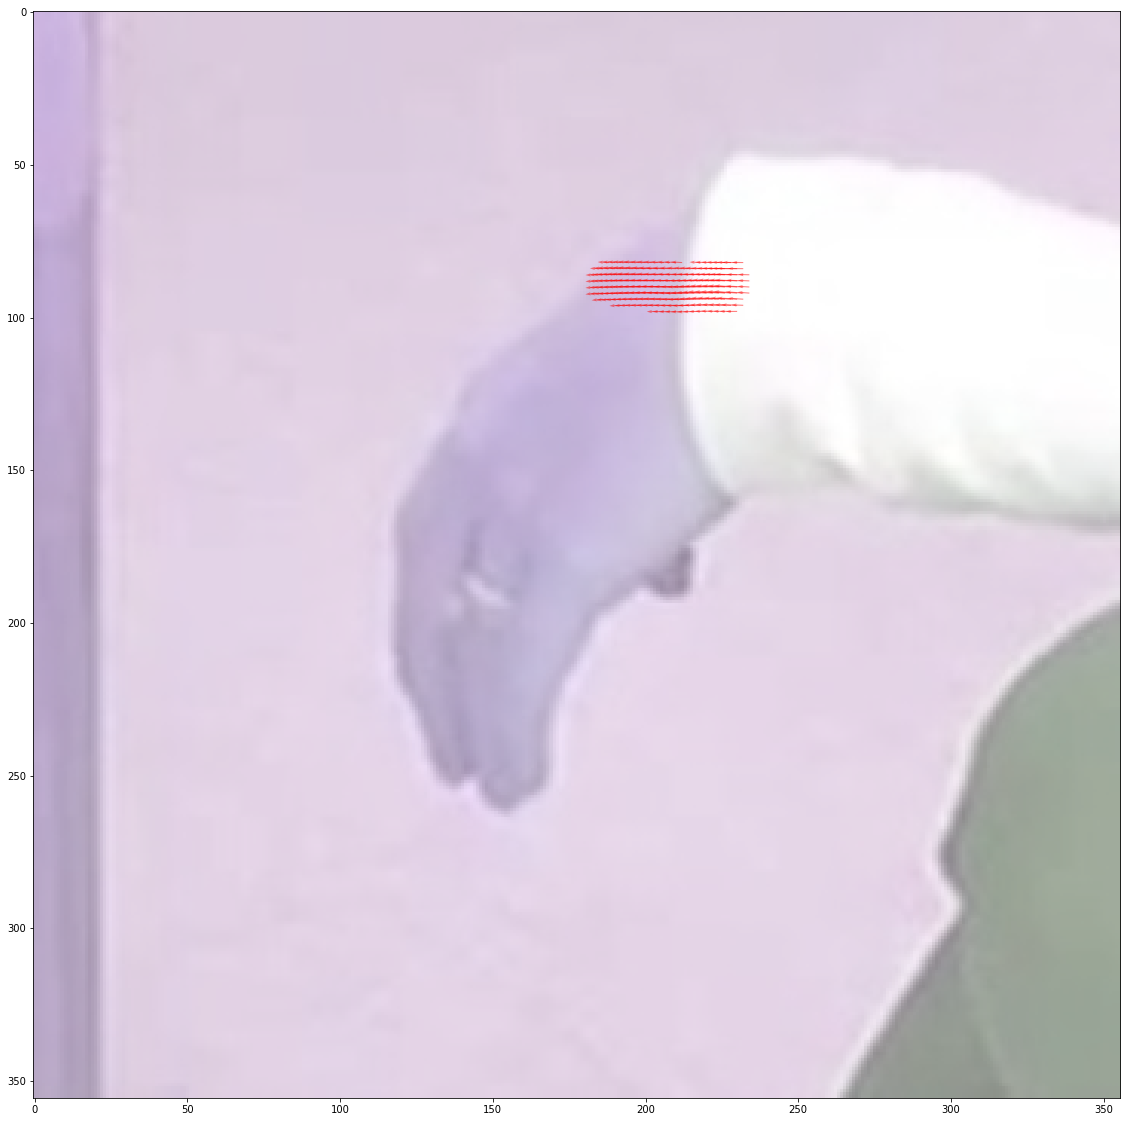

In [35]:
hhhh = 0
#22, 23 허벅지 vectormap
from numpy import ma
U = resized_vectormap[hhhh]
V = resized_vectormap[hhhh+1]*(-1)
#print(np.shape(U))
#print(np.shape(V))
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
#print(np.shape(X))
#print(np.shape(Y))
M = np.zeros(U.shape, dtype='bool')
#print(np.shape(M))
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

plt.figure()
plt.imshow(oriImg, alpha = .5)
s = 2
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)

In [38]:
"""hhhh = 2
#22, 23 허벅지 vectormap
from numpy import ma
U = resized_vectormap[hhhh]
V = resized_vectormap[hhhh+1]*(-1)
#print(np.shape(U))
#print(np.shape(V))
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
#print(np.shape(X))
#print(np.shape(Y))
M = np.zeros(U.shape, dtype='bool')
#print(np.shape(M))
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

plt.figure()
plt.imshow(oriImg, alpha = .5)
s = 2
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)"""

"hhhh = 2\n#22, 23 허벅지 vectormap\nfrom numpy import ma\nU = resized_vectormap[hhhh]\nV = resized_vectormap[hhhh+1]*(-1)\n#print(np.shape(U))\n#print(np.shape(V))\nX, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))\n#print(np.shape(X))\n#print(np.shape(Y))\nM = np.zeros(U.shape, dtype='bool')\n#print(np.shape(M))\nM[U**2 + V**2 < 0.5 * 0.5] = True\nU = ma.masked_array(U, mask=M)\nV = ma.masked_array(V, mask=M)\n\nplt.figure()\nplt.imshow(oriImg, alpha = .5)\ns = 2\nQ = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], \n               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')\n\nfig = matplotlib.pyplot.gcf()\nfig.set_size_inches(20, 20)"

In [39]:
"""hhhh = 4
#22, 23 허벅지 vectormap
from numpy import ma
U = resized_vectormap[hhhh]
V = resized_vectormap[hhhh+1]*(-1)
#print(np.shape(U))
#print(np.shape(V))
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
#print(np.shape(X))
#print(np.shape(Y))
M = np.zeros(U.shape, dtype='bool')
#print(np.shape(M))
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

plt.figure()
plt.imshow(oriImg, alpha = .5)
s = 2
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)"""

"hhhh = 4\n#22, 23 허벅지 vectormap\nfrom numpy import ma\nU = resized_vectormap[hhhh]\nV = resized_vectormap[hhhh+1]*(-1)\n#print(np.shape(U))\n#print(np.shape(V))\nX, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))\n#print(np.shape(X))\n#print(np.shape(Y))\nM = np.zeros(U.shape, dtype='bool')\n#print(np.shape(M))\nM[U**2 + V**2 < 0.5 * 0.5] = True\nU = ma.masked_array(U, mask=M)\nV = ma.masked_array(V, mask=M)\n\nplt.figure()\nplt.imshow(oriImg, alpha = .5)\ns = 2\nQ = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], \n               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')\n\nfig = matplotlib.pyplot.gcf()\nfig.set_size_inches(20, 20)"

In [40]:
"""hhhh = 6
#22, 23 허벅지 vectormap
from numpy import ma
U = resized_vectormap[hhhh]
V = resized_vectormap[hhhh+1]*(-1)
#print(np.shape(U))
#print(np.shape(V))
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
#print(np.shape(X))
#print(np.shape(Y))
M = np.zeros(U.shape, dtype='bool')
#print(np.shape(M))
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

plt.figure()
plt.imshow(oriImg, alpha = .5)
s = 2
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)"""

"hhhh = 6\n#22, 23 허벅지 vectormap\nfrom numpy import ma\nU = resized_vectormap[hhhh]\nV = resized_vectormap[hhhh+1]*(-1)\n#print(np.shape(U))\n#print(np.shape(V))\nX, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))\n#print(np.shape(X))\n#print(np.shape(Y))\nM = np.zeros(U.shape, dtype='bool')\n#print(np.shape(M))\nM[U**2 + V**2 < 0.5 * 0.5] = True\nU = ma.masked_array(U, mask=M)\nV = ma.masked_array(V, mask=M)\n\nplt.figure()\nplt.imshow(oriImg, alpha = .5)\ns = 2\nQ = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], \n               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')\n\nfig = matplotlib.pyplot.gcf()\nfig.set_size_inches(20, 20)"

In [41]:
"""hhhh = 8
#22, 23 허벅지 vectormap
from numpy import ma
U = resized_vectormap[hhhh]
V = resized_vectormap[hhhh+1]*(-1)
#print(np.shape(U))
#print(np.shape(V))
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
#print(np.shape(X))
#print(np.shape(Y))
M = np.zeros(U.shape, dtype='bool')
#print(np.shape(M))
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

plt.figure()
plt.imshow(oriImg, alpha = .5)
s = 2
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)"""

"hhhh = 8\n#22, 23 허벅지 vectormap\nfrom numpy import ma\nU = resized_vectormap[hhhh]\nV = resized_vectormap[hhhh+1]*(-1)\n#print(np.shape(U))\n#print(np.shape(V))\nX, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))\n#print(np.shape(X))\n#print(np.shape(Y))\nM = np.zeros(U.shape, dtype='bool')\n#print(np.shape(M))\nM[U**2 + V**2 < 0.5 * 0.5] = True\nU = ma.masked_array(U, mask=M)\nV = ma.masked_array(V, mask=M)\n\nplt.figure()\nplt.imshow(oriImg, alpha = .5)\ns = 2\nQ = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], \n               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')\n\nfig = matplotlib.pyplot.gcf()\nfig.set_size_inches(20, 20)"

In [42]:
"""hhhh = 10
#22, 23 허벅지 vectormap
from numpy import ma
U = resized_vectormap[hhhh]
V = resized_vectormap[hhhh+1]*(-1)
#print(np.shape(U))
#print(np.shape(V))
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
#print(np.shape(X))
#print(np.shape(Y))
M = np.zeros(U.shape, dtype='bool')
#print(np.shape(M))
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

plt.figure()
plt.imshow(oriImg, alpha = .5)
s = 2
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)"""

"hhhh = 10\n#22, 23 허벅지 vectormap\nfrom numpy import ma\nU = resized_vectormap[hhhh]\nV = resized_vectormap[hhhh+1]*(-1)\n#print(np.shape(U))\n#print(np.shape(V))\nX, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))\n#print(np.shape(X))\n#print(np.shape(Y))\nM = np.zeros(U.shape, dtype='bool')\n#print(np.shape(M))\nM[U**2 + V**2 < 0.5 * 0.5] = True\nU = ma.masked_array(U, mask=M)\nV = ma.masked_array(V, mask=M)\n\nplt.figure()\nplt.imshow(oriImg, alpha = .5)\ns = 2\nQ = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], \n               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')\n\nfig = matplotlib.pyplot.gcf()\nfig.set_size_inches(20, 20)"

In [43]:
"""hhhh = 12
#22, 23 허벅지 vectormap
from numpy import ma
U = resized_vectormap[hhhh]
V = resized_vectormap[hhhh+1]*(-1)
#print(np.shape(U))
#print(np.shape(V))
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
#print(np.shape(X))
#print(np.shape(Y))
M = np.zeros(U.shape, dtype='bool')
#print(np.shape(M))
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

plt.figure()
plt.imshow(oriImg, alpha = .5)
s = 2
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)"""

"hhhh = 12\n#22, 23 허벅지 vectormap\nfrom numpy import ma\nU = resized_vectormap[hhhh]\nV = resized_vectormap[hhhh+1]*(-1)\n#print(np.shape(U))\n#print(np.shape(V))\nX, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))\n#print(np.shape(X))\n#print(np.shape(Y))\nM = np.zeros(U.shape, dtype='bool')\n#print(np.shape(M))\nM[U**2 + V**2 < 0.5 * 0.5] = True\nU = ma.masked_array(U, mask=M)\nV = ma.masked_array(V, mask=M)\n\nplt.figure()\nplt.imshow(oriImg, alpha = .5)\ns = 2\nQ = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], \n               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')\n\nfig = matplotlib.pyplot.gcf()\nfig.set_size_inches(20, 20)"

In [44]:
"""hhhh = 14
#22, 23 허벅지 vectormap
from numpy import ma
U = resized_vectormap[hhhh]
V = resized_vectormap[hhhh+1]*(-1)
#print(np.shape(U))
#print(np.shape(V))
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
#print(np.shape(X))
#print(np.shape(Y))
M = np.zeros(U.shape, dtype='bool')
#print(np.shape(M))
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

plt.figure()
plt.imshow(oriImg, alpha = .5)
s = 2
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)"""

"hhhh = 14\n#22, 23 허벅지 vectormap\nfrom numpy import ma\nU = resized_vectormap[hhhh]\nV = resized_vectormap[hhhh+1]*(-1)\n#print(np.shape(U))\n#print(np.shape(V))\nX, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))\n#print(np.shape(X))\n#print(np.shape(Y))\nM = np.zeros(U.shape, dtype='bool')\n#print(np.shape(M))\nM[U**2 + V**2 < 0.5 * 0.5] = True\nU = ma.masked_array(U, mask=M)\nV = ma.masked_array(V, mask=M)\n\nplt.figure()\nplt.imshow(oriImg, alpha = .5)\ns = 2\nQ = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], \n               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')\n\nfig = matplotlib.pyplot.gcf()\nfig.set_size_inches(20, 20)"

In [45]:
"""hhhh = 16
#22, 23 허벅지 vectormap
from numpy import ma
U = resized_vectormap[hhhh]
V = resized_vectormap[hhhh+1]*(-1)
#print(np.shape(U))
#print(np.shape(V))
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
#print(np.shape(X))
#print(np.shape(Y))
M = np.zeros(U.shape, dtype='bool')
#print(np.shape(M))
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

plt.figure()
plt.imshow(oriImg, alpha = .5)
s = 2
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)"""

"hhhh = 16\n#22, 23 허벅지 vectormap\nfrom numpy import ma\nU = resized_vectormap[hhhh]\nV = resized_vectormap[hhhh+1]*(-1)\n#print(np.shape(U))\n#print(np.shape(V))\nX, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))\n#print(np.shape(X))\n#print(np.shape(Y))\nM = np.zeros(U.shape, dtype='bool')\n#print(np.shape(M))\nM[U**2 + V**2 < 0.5 * 0.5] = True\nU = ma.masked_array(U, mask=M)\nV = ma.masked_array(V, mask=M)\n\nplt.figure()\nplt.imshow(oriImg, alpha = .5)\ns = 2\nQ = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], \n               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')\n\nfig = matplotlib.pyplot.gcf()\nfig.set_size_inches(20, 20)"

In [46]:
"""hhhh = 18
#22, 23 허벅지 vectormap
from numpy import ma
U = resized_vectormap[hhhh]
V = resized_vectormap[hhhh+1]*(-1)
#print(np.shape(U))
#print(np.shape(V))
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
#print(np.shape(X))
#print(np.shape(Y))
M = np.zeros(U.shape, dtype='bool')
#print(np.shape(M))
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

plt.figure()
plt.imshow(oriImg, alpha = .5)
s = 2
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)"""

"hhhh = 18\n#22, 23 허벅지 vectormap\nfrom numpy import ma\nU = resized_vectormap[hhhh]\nV = resized_vectormap[hhhh+1]*(-1)\n#print(np.shape(U))\n#print(np.shape(V))\nX, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))\n#print(np.shape(X))\n#print(np.shape(Y))\nM = np.zeros(U.shape, dtype='bool')\n#print(np.shape(M))\nM[U**2 + V**2 < 0.5 * 0.5] = True\nU = ma.masked_array(U, mask=M)\nV = ma.masked_array(V, mask=M)\n\nplt.figure()\nplt.imshow(oriImg, alpha = .5)\ns = 2\nQ = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], \n               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')\n\nfig = matplotlib.pyplot.gcf()\nfig.set_size_inches(20, 20)"

In [47]:
"""hhhh = 20
#22, 23 허벅지 vectormap
from numpy import ma
U = resized_vectormap[hhhh]
V = resized_vectormap[hhhh+1]*(-1)
#print(np.shape(U))
#print(np.shape(V))
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
#print(np.shape(X))
#print(np.shape(Y))
M = np.zeros(U.shape, dtype='bool')
#print(np.shape(M))
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

plt.figure()
plt.imshow(oriImg, alpha = .5)
s = 2
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)"""

"hhhh = 20\n#22, 23 허벅지 vectormap\nfrom numpy import ma\nU = resized_vectormap[hhhh]\nV = resized_vectormap[hhhh+1]*(-1)\n#print(np.shape(U))\n#print(np.shape(V))\nX, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))\n#print(np.shape(X))\n#print(np.shape(Y))\nM = np.zeros(U.shape, dtype='bool')\n#print(np.shape(M))\nM[U**2 + V**2 < 0.5 * 0.5] = True\nU = ma.masked_array(U, mask=M)\nV = ma.masked_array(V, mask=M)\n\nplt.figure()\nplt.imshow(oriImg, alpha = .5)\ns = 2\nQ = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], \n               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')\n\nfig = matplotlib.pyplot.gcf()\nfig.set_size_inches(20, 20)"

In [48]:
"""hhhh = 22
#22, 23 허벅지 vectormap
from numpy import ma
U = resized_vectormap[hhhh]
V = resized_vectormap[hhhh+1]*(-1)
#print(np.shape(U))
#print(np.shape(V))
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
#print(np.shape(X))
#print(np.shape(Y))
M = np.zeros(U.shape, dtype='bool')
#print(np.shape(M))
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

plt.figure()
plt.imshow(oriImg, alpha = .5)
s = 2
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)"""

"hhhh = 22\n#22, 23 허벅지 vectormap\nfrom numpy import ma\nU = resized_vectormap[hhhh]\nV = resized_vectormap[hhhh+1]*(-1)\n#print(np.shape(U))\n#print(np.shape(V))\nX, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))\n#print(np.shape(X))\n#print(np.shape(Y))\nM = np.zeros(U.shape, dtype='bool')\n#print(np.shape(M))\nM[U**2 + V**2 < 0.5 * 0.5] = True\nU = ma.masked_array(U, mask=M)\nV = ma.masked_array(V, mask=M)\n\nplt.figure()\nplt.imshow(oriImg, alpha = .5)\ns = 2\nQ = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], \n               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')\n\nfig = matplotlib.pyplot.gcf()\nfig.set_size_inches(20, 20)"

In [49]:
"""hhhh = 24
#22, 23 허벅지 vectormap
from numpy import ma
U = resized_vectormap[hhhh]
V = resized_vectormap[hhhh+1]*(-1)
#print(np.shape(U))
#print(np.shape(V))
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
#print(np.shape(X))
#print(np.shape(Y))
M = np.zeros(U.shape, dtype='bool')
#print(np.shape(M))
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

plt.figure()
plt.imshow(oriImg, alpha = .5)
s = 2
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)"""

"hhhh = 24\n#22, 23 허벅지 vectormap\nfrom numpy import ma\nU = resized_vectormap[hhhh]\nV = resized_vectormap[hhhh+1]*(-1)\n#print(np.shape(U))\n#print(np.shape(V))\nX, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))\n#print(np.shape(X))\n#print(np.shape(Y))\nM = np.zeros(U.shape, dtype='bool')\n#print(np.shape(M))\nM[U**2 + V**2 < 0.5 * 0.5] = True\nU = ma.masked_array(U, mask=M)\nV = ma.masked_array(V, mask=M)\n\nplt.figure()\nplt.imshow(oriImg, alpha = .5)\ns = 2\nQ = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], \n               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')\n\nfig = matplotlib.pyplot.gcf()\nfig.set_size_inches(20, 20)"

In [50]:
"""hhhh = 26
#22, 23 허벅지 vectormap
from numpy import ma
U = resized_vectormap[hhhh]
V = resized_vectormap[hhhh+1]*(-1)
#print(np.shape(U))
#print(np.shape(V))
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
#print(np.shape(X))
#print(np.shape(Y))
M = np.zeros(U.shape, dtype='bool')
#print(np.shape(M))
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

plt.figure()
plt.imshow(oriImg, alpha = .5)
s = 2
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)"""

"hhhh = 26\n#22, 23 허벅지 vectormap\nfrom numpy import ma\nU = resized_vectormap[hhhh]\nV = resized_vectormap[hhhh+1]*(-1)\n#print(np.shape(U))\n#print(np.shape(V))\nX, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))\n#print(np.shape(X))\n#print(np.shape(Y))\nM = np.zeros(U.shape, dtype='bool')\n#print(np.shape(M))\nM[U**2 + V**2 < 0.5 * 0.5] = True\nU = ma.masked_array(U, mask=M)\nV = ma.masked_array(V, mask=M)\n\nplt.figure()\nplt.imshow(oriImg, alpha = .5)\ns = 2\nQ = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], \n               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')\n\nfig = matplotlib.pyplot.gcf()\nfig.set_size_inches(20, 20)"

In [51]:
"""hhhh = 28
#22, 23 허벅지 vectormap
from numpy import ma
U = resized_vectormap[hhhh]
V = resized_vectormap[hhhh+1]*(-1)
#print(np.shape(U))
#print(np.shape(V))
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
#print(np.shape(X))
#print(np.shape(Y))
M = np.zeros(U.shape, dtype='bool')
#print(np.shape(M))
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

plt.figure()
plt.imshow(oriImg, alpha = .5)
s = 2
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)"""

"hhhh = 28\n#22, 23 허벅지 vectormap\nfrom numpy import ma\nU = resized_vectormap[hhhh]\nV = resized_vectormap[hhhh+1]*(-1)\n#print(np.shape(U))\n#print(np.shape(V))\nX, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))\n#print(np.shape(X))\n#print(np.shape(Y))\nM = np.zeros(U.shape, dtype='bool')\n#print(np.shape(M))\nM[U**2 + V**2 < 0.5 * 0.5] = True\nU = ma.masked_array(U, mask=M)\nV = ma.masked_array(V, mask=M)\n\nplt.figure()\nplt.imshow(oriImg, alpha = .5)\ns = 2\nQ = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], \n               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')\n\nfig = matplotlib.pyplot.gcf()\nfig.set_size_inches(20, 20)"

In [52]:
"""hhhh = 30
#22, 23 허벅지 vectormap
from numpy import ma
U = resized_vectormap[hhhh]
V = resized_vectormap[hhhh+1]*(-1)
#print(np.shape(U))
#print(np.shape(V))
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
#print(np.shape(X))
#print(np.shape(Y))
M = np.zeros(U.shape, dtype='bool')
#print(np.shape(M))
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

plt.figure()
plt.imshow(oriImg, alpha = .5)
s = 2
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)"""

"hhhh = 30\n#22, 23 허벅지 vectormap\nfrom numpy import ma\nU = resized_vectormap[hhhh]\nV = resized_vectormap[hhhh+1]*(-1)\n#print(np.shape(U))\n#print(np.shape(V))\nX, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))\n#print(np.shape(X))\n#print(np.shape(Y))\nM = np.zeros(U.shape, dtype='bool')\n#print(np.shape(M))\nM[U**2 + V**2 < 0.5 * 0.5] = True\nU = ma.masked_array(U, mask=M)\nV = ma.masked_array(V, mask=M)\n\nplt.figure()\nplt.imshow(oriImg, alpha = .5)\ns = 2\nQ = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], \n               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')\n\nfig = matplotlib.pyplot.gcf()\nfig.set_size_inches(20, 20)"

In [53]:
"""hhhh = 32
#22, 23 허벅지 vectormap
from numpy import ma
U = resized_vectormap[hhhh]
V = resized_vectormap[hhhh+1]*(-1)
#print(np.shape(U))
#print(np.shape(V))
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
#print(np.shape(X))
#print(np.shape(Y))
M = np.zeros(U.shape, dtype='bool')
#print(np.shape(M))
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

plt.figure()
plt.imshow(oriImg, alpha = .5)
s = 2
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)"""

"hhhh = 32\n#22, 23 허벅지 vectormap\nfrom numpy import ma\nU = resized_vectormap[hhhh]\nV = resized_vectormap[hhhh+1]*(-1)\n#print(np.shape(U))\n#print(np.shape(V))\nX, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))\n#print(np.shape(X))\n#print(np.shape(Y))\nM = np.zeros(U.shape, dtype='bool')\n#print(np.shape(M))\nM[U**2 + V**2 < 0.5 * 0.5] = True\nU = ma.masked_array(U, mask=M)\nV = ma.masked_array(V, mask=M)\n\nplt.figure()\nplt.imshow(oriImg, alpha = .5)\ns = 2\nQ = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], \n               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')\n\nfig = matplotlib.pyplot.gcf()\nfig.set_size_inches(20, 20)"

In [54]:
"""hhhh = 34
#22, 23 허벅지 vectormap
from numpy import ma
U = resized_vectormap[hhhh]
V = resized_vectormap[hhhh+1]*(-1)
#print(np.shape(U))
#print(np.shape(V))
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
#print(np.shape(X))
#print(np.shape(Y))
M = np.zeros(U.shape, dtype='bool')
#print(np.shape(M))
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

plt.figure()
plt.imshow(oriImg, alpha = .5)
s = 2
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)"""

"hhhh = 34\n#22, 23 허벅지 vectormap\nfrom numpy import ma\nU = resized_vectormap[hhhh]\nV = resized_vectormap[hhhh+1]*(-1)\n#print(np.shape(U))\n#print(np.shape(V))\nX, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))\n#print(np.shape(X))\n#print(np.shape(Y))\nM = np.zeros(U.shape, dtype='bool')\n#print(np.shape(M))\nM[U**2 + V**2 < 0.5 * 0.5] = True\nU = ma.masked_array(U, mask=M)\nV = ma.masked_array(V, mask=M)\n\nplt.figure()\nplt.imshow(oriImg, alpha = .5)\ns = 2\nQ = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], \n               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')\n\nfig = matplotlib.pyplot.gcf()\nfig.set_size_inches(20, 20)"

In [55]:
"""hhhh = 36
#22, 23 허벅지 vectormap
from numpy import ma
U = resized_vectormap[hhhh]
V = resized_vectormap[hhhh+1]*(-1)
#print(np.shape(U))
#print(np.shape(V))
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
#print(np.shape(X))
#print(np.shape(Y))
M = np.zeros(U.shape, dtype='bool')
#print(np.shape(M))
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

plt.figure()
plt.imshow(oriImg, alpha = .5)
s = 2
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)"""

"hhhh = 36\n#22, 23 허벅지 vectormap\nfrom numpy import ma\nU = resized_vectormap[hhhh]\nV = resized_vectormap[hhhh+1]*(-1)\n#print(np.shape(U))\n#print(np.shape(V))\nX, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))\n#print(np.shape(X))\n#print(np.shape(Y))\nM = np.zeros(U.shape, dtype='bool')\n#print(np.shape(M))\nM[U**2 + V**2 < 0.5 * 0.5] = True\nU = ma.masked_array(U, mask=M)\nV = ma.masked_array(V, mask=M)\n\nplt.figure()\nplt.imshow(oriImg, alpha = .5)\ns = 2\nQ = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], \n               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')\n\nfig = matplotlib.pyplot.gcf()\nfig.set_size_inches(20, 20)"

In [56]:
"""hhhh = 38
#22, 23 허벅지 vectormap
from numpy import ma
U = resized_vectormap[hhhh]
V = resized_vectormap[hhhh+1]*(-1)
#print(np.shape(U))
#print(np.shape(V))
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
#print(np.shape(X))
#print(np.shape(Y))
M = np.zeros(U.shape, dtype='bool')
#print(np.shape(M))
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

plt.figure()
plt.imshow(oriImg, alpha = .5)
s = 2
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)"""

"hhhh = 38\n#22, 23 허벅지 vectormap\nfrom numpy import ma\nU = resized_vectormap[hhhh]\nV = resized_vectormap[hhhh+1]*(-1)\n#print(np.shape(U))\n#print(np.shape(V))\nX, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))\n#print(np.shape(X))\n#print(np.shape(Y))\nM = np.zeros(U.shape, dtype='bool')\n#print(np.shape(M))\nM[U**2 + V**2 < 0.5 * 0.5] = True\nU = ma.masked_array(U, mask=M)\nV = ma.masked_array(V, mask=M)\n\nplt.figure()\nplt.imshow(oriImg, alpha = .5)\ns = 2\nQ = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], \n               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')\n\nfig = matplotlib.pyplot.gcf()\nfig.set_size_inches(20, 20)"

In [57]:
"""hhhh = 40
#22, 23 허벅지 vectormap
from numpy import ma
U = resized_vectormap[hhhh]
V = resized_vectormap[hhhh+1]*(-1)
#print(np.shape(U))
#print(np.shape(V))
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
#print(np.shape(X))
#print(np.shape(Y))
M = np.zeros(U.shape, dtype='bool')
#print(np.shape(M))
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

plt.figure()
plt.imshow(oriImg, alpha = .5)
s = 2
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)"""

"hhhh = 40\n#22, 23 허벅지 vectormap\nfrom numpy import ma\nU = resized_vectormap[hhhh]\nV = resized_vectormap[hhhh+1]*(-1)\n#print(np.shape(U))\n#print(np.shape(V))\nX, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))\n#print(np.shape(X))\n#print(np.shape(Y))\nM = np.zeros(U.shape, dtype='bool')\n#print(np.shape(M))\nM[U**2 + V**2 < 0.5 * 0.5] = True\nU = ma.masked_array(U, mask=M)\nV = ma.masked_array(V, mask=M)\n\nplt.figure()\nplt.imshow(oriImg, alpha = .5)\ns = 2\nQ = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], \n               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')\n\nfig = matplotlib.pyplot.gcf()\nfig.set_size_inches(20, 20)"

In [36]:
all_peaks = []
peak_counter = 0

for part in range(22-1):
    map_ori = heatmap_avg[:,:,part]
    map = gaussian_filter(map_ori, sigma=3)
    
    map_left = np.zeros(map.shape)
    #print(np.shape(map_left))
    map_left[1:,:] = map[:-1,:]
    map_right = np.zeros(map.shape)
    map_right[:-1,:] = map[1:,:]
    map_up = np.zeros(map.shape)
    map_up[:,1:] = map[:,:-1]
    map_down = np.zeros(map.shape)
    map_down[:,:-1] = map[:,1:]
    
    peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up,map>=map_down, map > 0.07))#0.1
    peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0])) # note reverse
    peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
    id = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)

In [79]:
#limbSeq = [(0, 1), (0, 5), (0, 9), (0, 13), (0, 17), (1, 2), (5, 6), (9, 10), (13, 14), (17, 18), (2, 3), (6, 7), (10, 11), (14, 15), (18, 19), (3, 4), (7, 8), (11, 12), (15, 16), (19, 20)]#21개 조인트, 20개 limb
#mapIdx = [(0, 1),(8, 9),(16, 17),(24, 25),(32, 33),(2, 3),(10, 11), (18, 19), (26, 27), (34, 35), (4, 5), (12, 13), (20, 21), (28, 29), (36, 37), (6, 7), (14, 15), (22, 23), (30, 31), (38, 39)]

In [43]:
#limbSeq = [(0, 1), (0, 5), (0, 9), (0, 13), (0, 17), (1, 2), (2, 3), (3, 4), (5, 6), (6, 7), (7, 8), (9, 10), (10, 11), (11, 12), (13, 14), (14, 15), (15, 16), (17, 18), (18, 19), (19, 20)]#21개 조인트, 20개 limb
#mapIdx = [(0, 1),(8, 9),(16, 17),(24, 25),(32, 33),(2, 3),(4, 5),(6, 7),(10, 11),(12, 13),(14, 15),(18, 19),(20, 21),(22, 23),(26, 27),(28, 29),(30, 31),(34, 35),(36, 37),(38, 39)]

In [63]:
#limbSeq = [(0, 1), (1, 2), (2, 3), (3, 4), (0, 5), (5, 6), (6, 7), (7, 8), (0, 9), (9, 10), (10, 11), (11, 12), (0, 13),(13, 14), (14, 15), (15, 16), (0, 17), (17, 18), (18, 19), (19, 20)]#21개 조인트, 20개 limb#
#mapIdx = [(0, 1),(2, 3),(4, 5),(6, 7),(8, 9),(10, 11),(12, 13),(14, 15),(16, 17),(18, 19),(20, 21),(22, 23),(24, 25),(26, 27),(28, 29),(30, 31),(32, 33),(34, 35),(36, 37),(38, 39)]

In [37]:
limbSeq = [(1, 2),   (1, 6),  (1, 10), (1, 14), (1, 18), (2, 3),   (3, 4),   (4, 5),   (6, 7),  (7, 8),  (8, 9),   (10, 11), (11, 12), (12, 13), (14, 15), (15, 16), (16, 17), (18, 19), (19, 20), (20, 21)]#21개 조인트, 20개 limb
mapIdx  = [(22, 23), (30, 31),(38, 39),(46, 47),(54, 55),(24, 25), (26, 27), (28, 29), (32, 33),(34, 35),(36, 37), (40, 41), (42, 43), (44, 45), (48, 49), (50, 51), (52, 53), (56, 57), (58, 59), (60, 61)]

In [38]:
print(np.shape(paf_avg))
connection_all = []
special_k = []
mid_num = 20###########################################################################################
#paf_avg = resized_vectormap
for k in range(len(mapIdx)):
    score_mid = paf_avg[:,:,[x-22 for x in mapIdx[k]]]
    #print(np.shape(all_peaks))
    candA = all_peaks[limbSeq[k][0] - 1]#all_peaks[limbSeq[k][0]-1]#157
    candB = all_peaks[limbSeq[k][1] - 1]#all_peaks[limbSeq[k][1]-1]#246

    nA = len(candA)
    nB = len(candB)
    #print("nA, nB : ", nA, nB)
    indexA, indexB = limbSeq[k]
    #print("indexA, indexB : ", indexA, indexB)
    if(nA != 0 and nB != 0):
        connection_candidate = []
        for i in range(nA):
            for j in range(nB):
                vec = np.subtract(candB[j][:2], candA[i][:2])
                norm = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
                # failure case when 2 body parts overlaps
                if norm == 0:
                    continue
                vec = np.divide(vec, norm)
                
                startend = list(zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                               np.linspace(candA[i][1], candB[j][1], num=mid_num)))
                #print("startend : ",startend)
                vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                                  for I in range(len(startend))])

                vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                                  for I in range(len(startend))])

                score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                score_with_dist_prior = sum(score_midpts)/len(score_midpts) + min(0.5*oriImg.shape[0]/norm-1, 0)
                criterion1 = len(np.nonzero(score_midpts > 0.05)[0]) > 0.8 * len(score_midpts)
                criterion2 = score_with_dist_prior > 0
                if criterion1 and criterion2:
                    connection_candidate.append([i, j, score_with_dist_prior, score_with_dist_prior+candA[i][2]+candB[j][2]])
        connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
        connection = np.zeros((0,5))
        for c in range(len(connection_candidate)):
            i,j,s = connection_candidate[c][0:3]
            if(i not in connection[:,3] and j not in connection[:,4]):
                connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                if(len(connection) >= min(nA, nB)):
                    break
        connection_all.append(connection)
    else:
        special_k.append(k)
        connection_all.append([])

(356, 356, 44)


In [39]:
subset = -1 * np.ones((0, 23))######################################################
#print("subset1 : ", subset)
candidate = np.array([item for sublist in all_peaks for item in sublist])
print("candidate : ", candidate)
#print("all_peaks : ", all_peaks)
for k in range(len(mapIdx)):
    #print("--------------------------------------------")
    #print("k : ", k)
    #print("special_k : ", special_k)
    if k not in special_k:
        #print("k is not in special_k : ",k)
        partAs = connection_all[k][:,0]
        partBs = connection_all[k][:,1]
        indexA, indexB = np.array(limbSeq[k]) - 1
        
        #print("connection_all : ",connection_all)
        #print("connection_all[k] : ",connection_all[k])
        for i in range(len(connection_all[k])): #= 1:size(temp,1)
            #print("hello")
            found = 0
            subset_idx = [-1, -1]
            #print("subset's length :", len(subset))
            for j in range(len(subset)): #1:size(subset,1):
                #print("subset3 : ", subset)
                if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                    subset_idx[found] = j
                    found += 1
            #print("found : ",found)
            if found == 1:
                j = subset_idx[0]
                if(subset[j][indexB] != partBs[i]):
                    subset[j][indexB] = partBs[i]
                    subset[j][-1] += 1
                    subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
            elif found == 2: # if found 2 and disjoint, merge them
                j1, j2 = subset_idx
                #print ("found = 2")
                membership = ((subset[j1]>=0).astype(int) + (subset[j2]>=0).astype(int))[:-2]
                if len(np.nonzero(membership == 2)[0]) == 0: #merge
                    subset[j1][:-2] += (subset[j2][:-2] + 1)
                    subset[j1][-2:] += subset[j2][-2:]
                    subset[j1][-2] += connection_all[k][i][2]
                    subset = np.delete(subset, j2, 0)
                else: # as like found == 1
                    subset[j1][indexB] = partBs[i]
                    subset[j1][-1] += 1
                    subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

            # if find no partA in the subset, create a new subset
            elif not found and k < 20:
                row = -1 * np.ones(23)
                row[indexA] = partAs[i]
                row[indexB] = partBs[i]
                row[-1] = 2
                row[-2] = sum(candidate[connection_all[k][i,:2].astype(int), 2]) + connection_all[k][i][2]
                subset = np.vstack([subset, row])
#print("end~",subset)

candidate :  [[2.30000000e+02 9.30000000e+01 9.50794756e-01 0.00000000e+00]
 [1.17000000e+02 2.06000000e+02 1.35923564e-01 1.00000000e+00]
 [1.90000000e+02 9.30000000e+01 8.97958457e-01 2.00000000e+00]
 [1.20000000e+02 2.06000000e+02 1.15494087e-01 3.00000000e+00]
 [1.18000000e+02 2.06000000e+02 1.41618505e-01 4.00000000e+00]
 [1.41000000e+02 1.25000000e+02 9.81788874e-01 5.00000000e+00]
 [1.17000000e+02 1.65000000e+02 9.22592342e-01 6.00000000e+00]
 [1.17000000e+02 2.06000000e+02 1.76962361e-01 7.00000000e+00]
 [1.19000000e+02 2.06000000e+02 3.75194490e-01 8.00000000e+00]
 [1.25000000e+02 2.30000000e+02 3.65050673e-01 9.00000000e+00]
 [1.25000000e+02 2.30000000e+02 2.81307995e-01 1.00000000e+01]
 [1.41000000e+02 1.41000000e+02 9.60467696e-01 1.10000000e+01]
 [1.24000000e+02 2.06000000e+02 4.27380174e-01 1.20000000e+01]
 [1.32000000e+02 2.30000000e+02 7.90237010e-01 1.30000000e+01]
 [1.33000000e+02 2.54000000e+02 8.90158176e-01 1.40000000e+01]
 [1.49000000e+02 2.55000000e+02 1.66119903

In [40]:
# delete some rows of subset which has few parts occur
deleteIdx = [];
print(subset)
for i in range(len(subset)):
    print("subset[i][-1] : ", subset[i][-1])
    print("subset[i][-2]/subset[i][-1] : ",subset[i][-2]/subset[i][-1])
    if subset[i][-1] < 1 or subset[i][-2]/subset[i][-1] < 0.1:#0.1
        deleteIdx.append(i)
    #    print(i)
subset = np.delete(subset, deleteIdx, axis=0)
#print(subset)

[[ 0.          2.         -1.         -1.         -1.          5.
   6.          8.         10.         11.         12.         13.
  14.         16.         17.         18.         20.         21.
  22.         23.         25.         27.34546864 18.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
   7.          9.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.          0.78332297  2.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         24.         26.          1.00535867  2.        ]]
subset[i][-1] :  18.0
subset[i][-2]/subset[i][-1] :  1.5191927021588114
subset[i][-1] :  2.0
subset[i][-2]/subset[i][-1] :  0.39166148642255116
subset[i][-1] :  2.0
subset[i][-2]/subset[i][-1] :  0.5026793337973791


In [41]:
print(batch_img_path[index2])
test_image = batch_img_path[index2]

./dataset/Hands/hand_labels/Cropped_Resized_Image/073877803_02_l.jpg


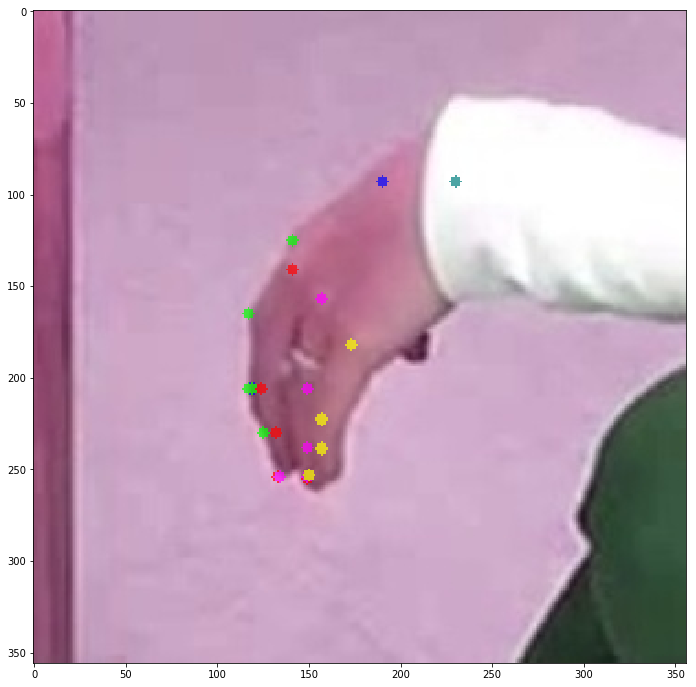

In [42]:
# visualize
colors = [[125, 125, 0], [255, 0, 0], [255, 0, 0], [255, 0, 0], [255, 0, 0], [0, 255, 0], [0, 255, 0],\
          [0, 255, 0], [0, 255, 0], [0, 0, 255], [0, 0, 255], [0, 0, 255], [0, 0, 255], [255, 0, 255],\
          [255, 0, 255], [255, 0, 255],[255, 0, 255], [0, 255, 255],   [0, 255, 255], [0, 255, 255], [0, 255, 255]]
cmap = matplotlib.cm.get_cmap('hsv')

#canvas = batch_img[index]# B,G,R order
canvas = cv2.imread(test_image) # B,G,R order

for i in range(21):
    rgba = np.array(cmap(1 - i/21. - 1./42))
    rgba[0:3] *= 255
    
    for j in range(len(all_peaks[i])):
        cv2.circle(canvas, all_peaks[i][j][0:2], 3, colors[i], thickness=-1)

oriImg = cv2.imread(test_image)
to_plot = cv2.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
plt.imshow(to_plot[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)

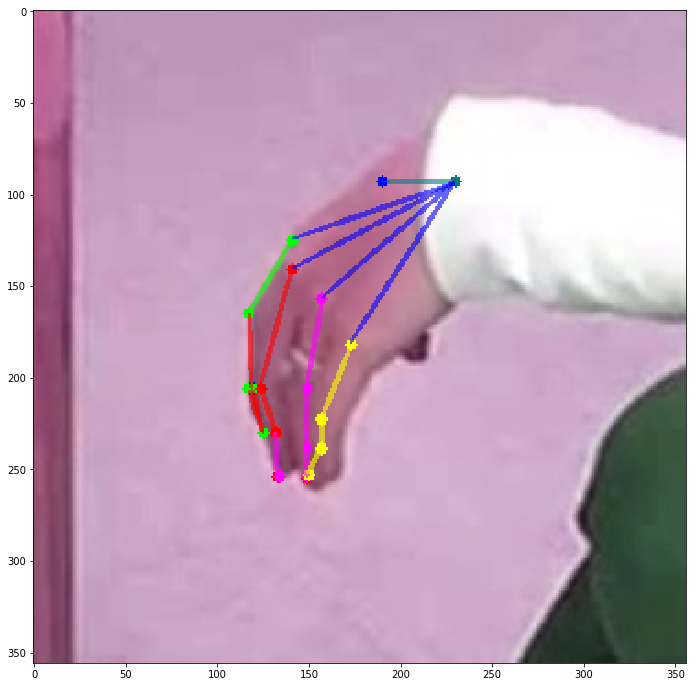

In [43]:
stickwidth = 1

for i in range(20):
    for n in range(len(subset)):
        index = subset[n][np.array(limbSeq[i])-1]
        #print("index : ", index)
        if -1 in index:
            continue
        #print("hello")
        cur_canvas = canvas.copy()
        Y = candidate[index.astype(int), 0]
        X = candidate[index.astype(int), 1]
        mX = np.mean(X)
        mY = np.mean(Y)
        length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
        angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
        polygon = cv2.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
        cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
        canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
        
plt.imshow(canvas[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)